In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import random

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix

tfk = tf.keras
tfkl = tfk.layers
seed = 100
plt.style.use('ggplot')


## Load data
Load augmented data (sliding window). Data are already scaled with robust scaler.

In [3]:
X = np.load(f'./augmented/X_stride1.npy')
y = np.load(f'./augmented/y_stride1.npy')

X.shape

(87024, 36, 6)

## Compute weights for classes

In [57]:
counter = np.bincount(y)
frequencies = 1 / counter
weights = frequencies * (y.shape[0] / frequencies.shape[0])

w_s = {}
for i, w in enumerate(weights):
    w_s[i] = w
w_s

{0: 6.099243061396131,
 1: 1.6508081038015026,
 2: 0.7487867836861125,
 3: 0.5300782106571157,
 4: 3.300864815657715,
 5: 1.3250502466654486,
 6: 0.6455977922193537,
 7: 3.0053874844591792,
 8: 1.6924154025670946,
 9: 0.2595840641443247,
 10: 2.649616368286445,
 11: 4.026651860077735}

In [58]:
1 / frequencies

array([ 1189.,  4393.,  9685., 13681.,  2197.,  5473., 11233.,  2413.,
        4285., 27937.,  2737.,  1801.])

In [59]:
def evaluate_model(m, X_val, y_val):
    """
    This method computes the confusion matrix and recall, precision and f1-score for each class.
    :param m: model to evaluate.
    :param X_val: samples to use for the evaluation. X_val cannot be a tf.Dataset object.
    :param y_val: labels for each element of X_val. y_val cannot be a tf.Dataset object.
    :return pandas.DataFrame containing the confusion matrix and pandas.Dataframe whose rows 
    are recall,precision, f1-score and support, whereas columns are the labels.
    """
    y_pred = m.predict(X_val)
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y_val, axis=1)
    
    c_m = pd.DataFrame(confusion_matrix(y_true, y_pred, normalize='true'))
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    report = pd.DataFrame(report)
    report = report.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1)
    
    return c_m, report

# Soft f1 loss function
[thanks to](https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric/notebook)

In [60]:
def soft_f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

## Split data
loaded data use sliding window with stride 1, this means there are multiple samples sharing the same subset of timestamps. Samples sharing the same subset of timestamp must stay in the same set, otherwise we overfit the validation set and we vanish the help given by the validation set.


In [61]:
df = pd.DataFrame({'y': y})
# getting indexes of the first instance for each label
starting_indexes = list(df.drop_duplicates(keep='first').index.values)
# getting indexes of the last instance for each label
ending_indexes = starting_indexes[1:] + [df.index.values[-1] + 1]

X_train = None
X_val = None

y_train = None
y_val = None

train_percentage = 0.85


for label, starting_index, ending_index in zip(range(12), starting_indexes, ending_indexes):
    
    split_index = int(train_percentage * (ending_index - starting_index))
    split_index += starting_index
    assert split_index + 36 > starting_index
    if X_train is None:
        X_train = X[starting_index: split_index, :, :].copy()
        y_train = y[starting_index: split_index].copy()
        
        X_val = X[split_index + 36: ending_index, :, :].copy()
        y_val = y[split_index + 36: ending_index].copy()
    else:
        X_train = np.append(X_train, X[starting_index: split_index, :, :], axis=0)
        y_train = np.append(y_train, y[starting_index: split_index])
        
        X_val = np.append(X_val, X[split_index + 36: ending_index, :, :], axis=0)
        y_val = np.append(y_val, y[split_index + 36: ending_index])

        
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(73966, 36, 6) (12626, 36, 6) (73966, 12) (12626, 12)


In [62]:
def residual_block_1D(input_tensor, kernel_size, filters, l2):
    """
    This method returns a revisited version of a residual blok.
    :param input_tensor: tensor whose output go into the residual block.
    :param kernel_size: integer representing the window size in the convolution.
    :param filters: number of filters.
    :param l2: float penality term for the L2 regularizer. 
    """
    x = tfkl.BatchNormalization(momentum=0)(input_tensor)
    x = tfk.activations.relu(x)
    x = tfkl.Conv1D(filters=filters, kernel_size=1, padding='same', kernel_regularizer=tfk.regularizers.L2(l2))(x)
    
    x = tfkl.BatchNormalization(momentum=0)(x)
    x = tfk.activations.relu(x)
    x = tfkl.Conv1D(filters=filters, kernel_size=kernel_size, padding='same', kernel_regularizer=tfk.regularizers.L2(l2))(x)
    
    # uncomment the following lines to get the original residual block.
    #x = tfkl.BatchNormalization(momentum=0)(x)
    #x = tfk.activations.relu(x)
    #x = tfkl.Conv1D(filters=filters, kernel_size=1, padding='same', kernel_regularizer=tfk.regularizers.L2(l2))(x)   
    
    x = tfkl.Add()([input_tensor, x])
    
    return x

In [117]:
def build_resnet1d(input_shape, n_classes, filters=64, l2_penalty=0, l2_softmax=0):
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    
    x = tfkl.Conv1D(filters=filters, kernel_size=3, padding='same')(input_layer)
    x = tfkl.MaxPooling1D()(x)
    
    x = residual_block_1D(x, 3, filters, l2_penalty)
    x = residual_block_1D(x, 3, filters, l2_penalty)
    x = residual_block_1D(x, 3, filters, l2_penalty)
    x = tfkl.MaxPooling1D()(x)
    
    filters = filters * 2
    x = tfkl.Conv1D(filters=filters, kernel_size=3, padding='same')(x)
    x = residual_block_1D(x, 3, filters, l2_penalty)
    x = residual_block_1D(x, 3, filters, l2_penalty)
    #x = residual_block_1D(x, 3, filters, l2_penalty)
    #x = residual_block_1D(x, 3, filters, l2_penalty)
    #x = tfkl.MaxPooling1D()(x)
    
    """filters = filters * 2
    x = tfkl.Conv1D(filters=filters, kernel_size=3, padding='same')(x)
    x = residual_block_1D(x, 3, filters, l2_penalty)
    x = residual_block_1D(x, 3, filters, l2_penalty)
    x = residual_block_1D(x, 3, filters, l2_penalty)
    x = residual_block_1D(x, 3, filters, l2_penalty)
    x = tfkl.MaxPooling1D()(x)"""
    
    """filters = filters * 2
    x = tfkl.Conv1D(filters=filters, kernel_size=3, padding='same')(x)
    x = residual_block_1D(x, 3, filters, l2_penalty)
    x = residual_block_1D(x, 3, filters, l2_penalty)
    x = residual_block_1D(x, 3, filters, l2_penalty)
    x = residual_block_1D(x, 3, filters, l2_penalty)
    x = tfkl.MaxPooling1D()(x)"""
    
    x = tfkl.GlobalAveragePooling1D()(x)
    output_layer = tfkl.Dense(n_classes, activation='softmax', kernel_regularizer=tfk.regularizers.L2(l2_softmax))(x)
    
    model = tfk.models.Model(inputs=input_layer, outputs=output_layer, name='model')
    return model

In [ ]:
epochs = 200
batch_size = 128
lr = 1e-3

e_s = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    restore_best_weights=True,
    patience=50
)

r_LR = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=15,
    mode='max',
    verbose=1,
    min_lr=1e-5
)

In [118]:
model = build_resnet1d(X_train.shape[1:], 12, filters=64)

categorical_loss = tfk.losses.CategoricalCrossentropy()

model.compile(loss=categorical_loss, optimizer=tfk.optimizers.Adam(learning_rate=lr), metrics='accuracy')

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
    shuffle=True,
    class_weight=w_s,
    workers=4,
    use_multiprocessing=True,
)

Epoch 1/200
578/578 [==============================] - 12s 15ms/step - loss: 2.4043 - accuracy: 0.2864 - val_loss: 2.0082 - val_accuracy: 0.3105
Epoch 2/200
578/578 [==============================] - 8s 14ms/step - loss: 1.3475 - accuracy: 0.4056 - val_loss: 1.9548 - val_accuracy: 0.3479
Epoch 3/200
578/578 [==============================] - 8s 14ms/step - loss: 1.1331 - accuracy: 0.4558 - val_loss: 1.7535 - val_accuracy: 0.3749
Epoch 4/200
578/578 [==============================] - 8s 14ms/step - loss: 1.1417 - accuracy: 0.4803 - val_loss: 2.0395 - val_accuracy: 0.3920
Epoch 5/200
578/578 [==============================] - 8s 14ms/step - loss: 1.2732 - accuracy: 0.4801 - val_loss: 3.6223 - val_accuracy: 0.4011
Epoch 6/200
578/578 [==============================] - 8s 14ms/step - loss: 0.8441 - accuracy: 0.5489 - val_loss: 1.8768 - val_accuracy: 0.4647
Epoch 7/200
578/578 [==============================] - 8s 13ms/step - loss: 0.7729 - accuracy: 0.5755 - val_loss: 3.3453 - val_accuracy

0.721051812171936


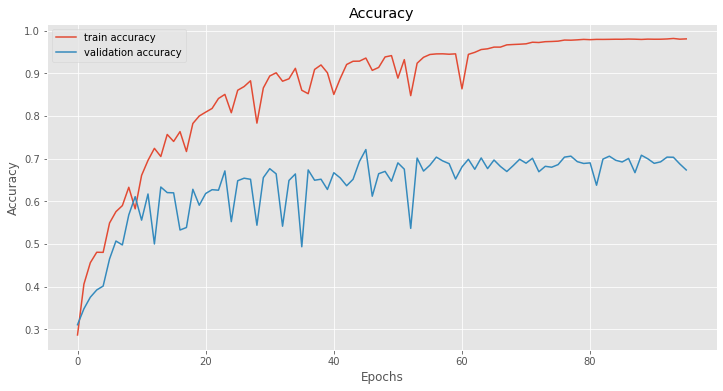

In [119]:
print(np.max(history.history['val_accuracy']))
x_axis = np.arange(len(history.history['val_accuracy']))

plt.figure(figsize=(12, 6))
plt.title("Accuracy")
plt.plot(x_axis, history.history["accuracy"], label="train accuracy")
plt.plot(x_axis, history.history["val_accuracy"], label="validation accuracy")


plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [120]:
c_m, report = evaluate_model(model, X_val, y_val)

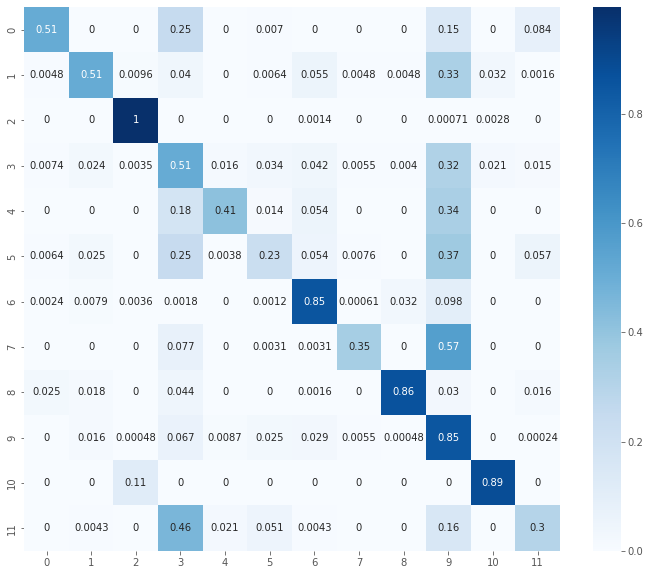

In [121]:
plt.figure(figsize=(12, 10))
sns.heatmap(c_m, cmap='Blues', annot=True)
plt.show()

In [122]:
report

,0,1,2,3,4,5,6,7,8,9,10,11
precision,0.634783,0.666667,0.956581,0.578740,0.613065,0.475936,0.824150,0.721519,0.888325,0.680170,0.832080,0.415205
recall,0.510490,0.510433,0.995060,0.510164,0.414966,0.226752,0.852638,0.349693,0.864909,0.848616,0.885333,0.302128
f1-score,0.565891,0.578182,0.975441,0.542292,0.494929,0.307161,0.838152,0.471074,0.876461,0.755113,0.857881,0.349754
support,143.000000,623.000000,1417.000000,2017.000000,294.000000,785.000000,1649.000000,326.000000,607.000000,4155.000000,375.000000,235.000000


In [123]:
model.save('models/')

2022-12-16 18:31:06.118130: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
